In the Siamese Network, I used one such methodology. 
The model is trained with convolutional neural network with RMSprop as an optimiser to update the parameters of all the layers using back propagation for both the lines.

Two dataset have been worked out.

Triplet Loss -

1. 20 alphabets - train & other 6 test - Vertical Split

    Acc - test: 70.42378917378917 (for test set) 
    - 
    Positive similarity: 0.20598295 -
    Negative similarity 0.18979926 (for training set)

2. 26 alphabets - train & test - Horizontal Split

    Acc - test: 72.06604409357851 (for test set) 
    - Positive similarity: 0.2059852 -
    Negative similarity 0.189592 (for training set)

Contrastive Loss -

1. 20 alphabets - train & other 6 test - Vertical Split

    Acc - test: 95.40242165242165 (for test set) 
    - Positive similarity: 0.20598295 -
    Negative similarity 0.18979926 (for training set)

2. 26 alphabets - train & test - Horizontal Split

    Acc - test: 95.51121594300568 (for test set) 
    - Positive similarity: 0.2059852 - 
    Negative similarity 0.18961547 (for training set)

In [107]:
import keras
from __future__ import absolute_import
from __future__ import print_function
import numpy as np
import tensorflow as tf
import random
from torchvision.datasets import EMNIST
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D, Activation,AveragePooling2D
from keras.optimizers import RMSprop
from keras import backend as K
import matplotlib.pyplot as plt
from PIL import Image

!pip install -U tensorflow-addons
import tensorflow_addons as tfa


In [135]:
# the data, split between train and test sets

dataset = EMNIST(root="data/", split="letters", download=True, train=True, )                
test_dataset = EMNIST(root="data/", split="letters", download=True, train=False, )

print("EMNIST dataset:", len(dataset) + len(test_dataset))
print("Training dataset:    ",len(dataset))
print("Testing dataset:     ",len(test_dataset))

l = dataset.classes
l.sort()
print("No of classes: ",len(l))
print("List of all classes")
print(l)

(x_train, y_train), (x_test, y_test) = (dataset.train_data,dataset.train_labels),(test_dataset.test_data,test_dataset.test_labels)
#load_data()



EMNIST dataset: 145600
Training dataset:     124800
Testing dataset:      20800
No of classes:  27
List of all classes
['N/A', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:52: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [136]:
np.shape(y_train)

torch.Size([124800])

In [137]:
# preprocessing 

x_train = np.array(x_train.reshape(x_train.shape[0], 28, 28, 1))
x_test = np.array(x_test.reshape(x_test.shape[0], 28, 28, 1))
# input_shape = (1, 28, 28)
print(x_train.shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

input_shape = x_train.shape[1:]
#input_shape = (28, 28, 1)


(124800, 28, 28, 1)


In [134]:
# This cell must be activated for 20 train - 6 test dataset.

Xtr = x_train[:int(20/26*len(x_train))]
Ytr = y_train[:int(20/26*len(y_train))]
Xte = x_train[int(20/26*len(y_train)):]
Yte = y_train[int(20/26*len(y_train)):]
x_train = Xtr
y_train = Ytr
x_test = Xte
y_test = Yte
print(np.shape(x_train))

(96000, 28, 28, 1)


In [138]:
# Network parameters

num_classes = 26
epochs = 10


In [139]:
# Func which help

def euclid_dis(vects):
  x,y = vects
  sum_square = K.sum(K.square(x-y), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sum_square, K.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def triplet_loss(y_true, y_pred):
    return tfa.losses.triplet_semihard_loss(y_true, y_pred) 
    
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

def create_pairs(x, alpha_indices):
  pairs = []
  labels = []
  n = min([len(alpha_indices[d]) for d in range(num_classes)]) - 1
  print(n)
  for d in range(num_classes):
    for i in range(n):
      z1, z2 = alpha_indices[d][i], alpha_indices[d][i+1]
      pairs += [[x[z1], x[z2]]]
      inc = random.randrange(1, num_classes)
      dn = (d + inc) % num_classes
      z1, z2 = alpha_indices[d][i], alpha_indices[dn][i]
      pairs += [[x[z1], x[z2]]]
      labels += [1,0]
  print(len(labels))
  return np.array(pairs), np.array(labels)


In [140]:
# Siamese Net 
# Conv Net with 3 layers of Convolutions and 

def create_base_net(input_shape):
  
  input = Input(shape = input_shape)
  x = Conv2D(4, (5,5), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(8, (5,5), activation = 'relu')(input)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Conv2D(16, (5,5), activation = 'tanh')(x)
  x = AveragePooling2D(pool_size = (2,2))(x)
  x = Flatten()(x)
  x = Dense(128, activation = 'tanh')(x)
  x = Dense(26, activation = 'sigmoid')(x)
  model = Model(input, x)
  model.summary()
  return model

def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))



In [141]:
# create training+test positive and negative pairs
alpha_indices = [np.where(y_train == i)[0] for i in range(1,27)]
print(np.shape(alpha_indices))
tr_pairs, tr_y = create_pairs(x_train, alpha_indices)
tr_y = tr_y.astype('float32')

alpha_indices = [np.where(y_test == i)[0] for i in range(1,27)]
te_pairs, te_y = create_pairs(x_test, alpha_indices)
te_y = te_y.astype('float32')
#print(np.shape(tr_pairs), np.shape(tr_y),np.shape(te_pairs), np.shape(te_y))
#print((np.array(tr_pairs[0])))

(26, 4800)
4799
249548
799
41548


In [142]:
print(np.shape(tr_pairs))
print(np.shape(tr_y))
print(np.shape(te_pairs))
print(np.shape(te_y))
#

(249548, 2, 28, 28, 1)
(249548,)
(41548, 2, 28, 28, 1)
(41548,)


In [145]:
# network definition
base_network = create_base_net(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclid_dis,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)
rms = RMSprop()
model.compile(loss=triplet_loss, optimizer=rms, metrics=[accuracy])
#model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_34 (InputLayer)        [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 24, 24, 8)         208       
_________________________________________________________________
average_pooling2d_34 (Averag (None, 12, 12, 8)         0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 8, 8, 16)          3216      
_________________________________________________________________
average_pooling2d_35 (Averag (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               328

In [146]:
# train
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y, batch_size = 128, epochs=epochs)


Epoch 1/10
1950/1950 [==============================] - 24s 11ms/step - loss: 0.9521 - accuracy: 0.5728
Epoch 2/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.8103 - accuracy: 0.5767
Epoch 3/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.7179 - accuracy: 0.6071
Epoch 4/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.6549 - accuracy: 0.6310
Epoch 5/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.6048 - accuracy: 0.6516
Epoch 6/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.5735 - accuracy: 0.6670
Epoch 7/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.5469 - accuracy: 0.6799
Epoch 8/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.5199 - accuracy: 0.6919
Epoch 9/10
1950/1950 [==============================] - 22s 11ms/step - loss: 0.4974 - accuracy: 0.7004
Epoch 10/10
1950/1950 [==============================] - 22s 11m

In [147]:
# compute final accuracy on test set
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)
print('Acc - test: ' + str(100 * te_acc))


Acc - test: 70.28978530855878


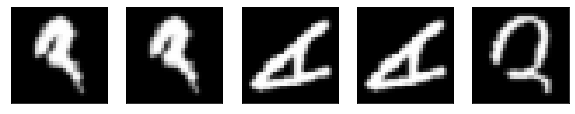

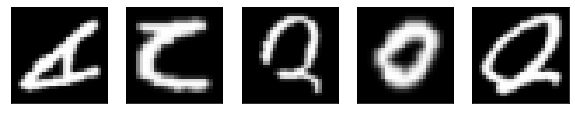

In [148]:
number_of_items = 5

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( te_pairs[item,0], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

plt.figure(figsize=(10, 5))
for item in range(number_of_items):
    display = plt.subplot(1, number_of_items,item+1)
    im = tf.keras.preprocessing.image.array_to_img( te_pairs[item,1], data_format=None, scale=True,dtype=None)
    plt.imshow(im, cmap="gray")
    display.get_xaxis().set_visible(False)
    display.get_yaxis().set_visible(False)
plt.show()

In [149]:
# Cosine Similarity 

pos, neg = [], []
for index in range(len(tr_pairs)):
  if tr_y[index] == 1:
    pos.append(tr_pairs[index])
  else:
    neg.append(tr_pairs[index])
pos = np.array(pos)
neg = np.array(neg)
print(np.shape(pos))
print(np.shape(neg))
np.shape(tr_y)

(124774, 2, 28, 28, 1)
(124774, 2, 28, 28, 1)


(249548,)

In [150]:
cosine_similarity = tf.keras.metrics.CosineSimilarity()

positive_similarity = cosine_similarity(pos[:, 0], pos[:, 1])
print("Positive similarity:", positive_similarity.numpy())

negative_similarity = cosine_similarity(neg[:, 0], neg[:, 1])
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.2059852
Negative similarity 0.189592


In [151]:
tr_y

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)